# Pitchbook Generator

# <span style='color:darkblue'>Outline</span>

* [General Overview](#chapterA)
* [Code](#chapterB)
    * [Generate_Company_Overview Function](#section_1)
    * [Generate_Industry_Overview Function](#section_2)
    * [Generate_Valuation Function](#section_3)
    * .[Generate_Pitchbook Function](#section_4)
* [Demonstration](#chapterC)

# General Overview <a class="anchor" id="chapterA"></a>

#### Description 
Pitchbook is information layout used by financial intermediaries advising on the sale or disposal of the shares or assets of a business. It consists of a careful arrangement and analysis of the investment considerations of the client business and is presented to investors and potential investors with the intent of providing them the information necessary for them to make a decision to buy or invest in the client business.

Our product is an automatised pitchbook generator developed in Python using Eikon API.

#### Value Proposition for Refinitiv
- Incentives Refinitiv's clientel to transform from excel into programming
- Expands Workbook's portfolio
- Exhibits a wide array of dimensionality of the API in a single function
- Creates a layout for future projects
    
#### Target users and use cases (Arjun)


#### Explain structure of the project (Arjun)


#### And potential limitations (Andrew)


#### And how we could add different functionalities (Andrew)

# Code <a class="anchor" id="chapterB"></a>

In [11]:
import eikon as ek
import numpy as np
from numpy import where
from numpy import unique
import pandas as pd
from sklearn.linear_model import LinearRegression
import pylab as plt
import warnings
import configparser
from fpdf import FPDF
import requests
import dataframe_image as dfi
cfg = configparser.ConfigParser()
cfg.read('rdp.cfg',encoding='utf-8')
warnings.filterwarnings("ignore")
ek.set_app_key('97c2624d47174658875191d2277aa66652b67832') 

## Generate_Company_Overview Function <a class="anchor" id="section_1"></a>

In [23]:
def generate_company_overview(ticker):
    # Request Header Information for RIC
    df, err = ek.get_data(ticker, "TR.CommonName(),TR.HeadquartersCountry,TR.TRBCIndustryGroup,TR.GICSSector,TR.CompanyMarketCap.Currency")
    #Request Exchange for Primary Quote RIC
    df_2, err = ek.get_data(ticker,"TR.PrimaryQuote")
    df_3, err = ek.get_data(df_2.at[0,'Primary Quote RIC'],"TR.ExchangeName")
    df['Exchange Name'] = [df_3.at[0,'Exchange Name']]
    df.dfi.export('header_info.png')



    '''
    GENERAL INFORMATION
    '''

    dfGen, err = ek.get_data(ticker, 'TR.PriceClose;TR.Price52WeekHigh;TR.PricePctChg52WkHigh;TR.Price52WeekLow;TR.PricePctChg52WkLow;TR.PriceTargetMedian',{'Curn':df.at[0,'Currency']})
    dfGen2, err = ek.get_data(ticker, 'TR.BetaFiveYear;TR.DividendYield;TR.SharesOutstanding;TR.FreeFloat;TR.FreeFloatPct();TR.CompanyMarketCap;TR.EV',{'Scale':6,'Curn':df.at[0,'Currency']})

    #calc implied profit
    dfGen['Implied Profit'] = (dfGen.at[0,'Price Target - Median']/dfGen.at[0,'Price Close'] - 1)*100

    # results as simple lists
    listGenNames = dfGen.columns.tolist()
    listGen = dfGen.iloc[0].tolist()
    listGen2Names = dfGen2.columns.tolist()
    listGen2 = dfGen2.iloc[0].tolist()

    #remove RIC
    listGenNames.pop(0)
    listGen.pop(0)
    listGen2Names.pop(0)
    listGen2.pop(0)

    dataDictGen= {'Metric ': listGenNames, 'Value ': listGen , 'Metric': listGen2Names, 'Value': listGen2}
    dfGenX = pd.DataFrame(dataDictGen)
    dfGenX.dfi.export('general_information.png')


    '''
    CONSENSUS RECOMMENDATION
    '''


    df6, err = ek.get_data(ticker, 'TR.RecLabel();TR.NumOfRecommendations();TR.NumEstRevisingUp;TR.NumEstRevisingDown',
                           {'WP': '30d', 'EstimateMeasure': 'EPS'})

    df6.dfi.export('consensus_recommendation.png')



    '''
    ESTIMATES 
    '''

    # Retrieve Estimates into Data Frames per Period

    # FY0
    dfFY0, err = ek.get_data(ticker, 'TR.RevenueActValue;TR.EBITDAActValue;TR.EPSActValue',
                             {'Period': 'FY0', 'Scale': '6', 'Curn': df.at[0, 'Currency']})
    # FY1
    dfFY1, err = ek.get_data(ticker,
                             'TR.RevenueMeanEstimate;TR.RevenueHigh;TR.RevenueLow;TR.EBITDAMean;TR.EBITDAHigh;TR.EBITDALow;TR.EPSMeanEstimate;TR.EPSHigh;TR.EPSLow',
                             {'Period': 'FY1', 'scale': '6', 'curn': df.at[0, 'Currency']})
    dfFY1_2, err = ek.get_data(ticker,
                               'TR.RevenueMeanEstimate; TR.EBITDAMean; TR.EPSMeanEstimate',
                               {'Period': 'FY1', 'RollPeriods': 'false', 'Scale': 6, 'Curn': df.at[0, 'Currency'],
                                'SDate': '-1AM'})
    # FY2
    dfFY2, err = ek.get_data(ticker,
                             'TR.RevenueMeanEstimate;TR.RevenueHigh;TR.RevenueLow;TR.EBITDAMean;TR.EBITDAHigh;TR.EBITDALow;TR.EPSMeanEstimate;TR.EPSHigh;TR.EPSLow',
                             {'Period': 'FY2', 'scale': '6', 'curn': df.at[0, 'Currency']})
    dfFY2_2, err = ek.get_data(ticker, 'TR.RevenueMeanEstimate;TR.EBITDAMean;TR.EPSMeanEstimate',
                               {'Period': 'FY2', 'RollPeriods': 'false', 'Scale': 6, 'Curn': df.at[0, 'Currency'],
                                'SDate': '-1AM'})

    ### DEBUG display(dfFY0,dfFY1,dfFY1_2, dfFY2, dfFY2_2)


    # Create a dictionary out of results, and structure a single multi-row Data Frame

    # initialise results per column
    data = {'Sales (MIL) Mean EST':
                [dfFY0.at[0, 'Revenue - Actual'], dfFY1.at[0, 'Revenue - Mean Estimate'], '',
                 dfFY2.at[0, 'Revenue - Mean Estimate'], ''],
            'High Est':
                ['', dfFY1.at[0, 'Revenue - High'],
                 (dfFY1.at[0, 'Revenue - High'] / dfFY1.at[0, 'Revenue - Mean Estimate'] - 1) * 100,
                 dfFY2.at[0, 'Revenue - High'],
                 (dfFY2.at[0, 'Revenue - High'] / dfFY2.at[0, 'Revenue - Mean Estimate'] - 1) * 100],
            'Low Est':
                ['', dfFY1.at[0, 'Revenue - Low'],
                 (dfFY1.at[0, 'Revenue - Low'] / dfFY1.at[0, 'Revenue - Mean Estimate'] - 1) * 100,
                 dfFY2.at[0, 'Revenue - Low'],
                 (dfFY2.at[0, 'Revenue - Low'] / dfFY2.at[0, 'Revenue - Mean Estimate'] - 1) * 100],
            'Est. 30 30 Days Ago':
                ['', dfFY1_2.at[0, 'Revenue - Mean Estimate'],
                 (dfFY1_2.at[0, 'Revenue - Mean Estimate'] / dfFY1.at[0, 'Revenue - Mean Estimate'] - 1) * 100,
                 dfFY2_2.at[0, 'Revenue - Mean Estimate'],
                 (dfFY2_2.at[0, 'Revenue - Mean Estimate'] / dfFY2.at[0, 'Revenue - Mean Estimate'] - 1) * 100],
            'EBITDA (MIL) Mean Est.':
                [dfFY0.at[0, 'EBITDA - Actual'], dfFY1.at[0, 'EBITDA - Mean'], '', dfFY2.at[0, 'EBITDA - Mean'], ''],
            'High Est.':
                ['', dfFY1.at[0, 'EBITDA - High'],
                 (dfFY1.at[0, 'EBITDA - High'] / dfFY1.at[0, 'EBITDA - Mean'] - 1) * 100,
                 dfFY2.at[0, 'EBITDA - High'], (dfFY2.at[0, 'EBITDA - High'] / dfFY2.at[0, 'EBITDA - Mean'] - 1) * 100],
            'Low Est.':
                ['', dfFY1.at[0, 'EBITDA - Low'],
                 (dfFY1.at[0, 'EBITDA - Low'] / dfFY1.at[0, 'EBITDA - Mean'] - 1) * 100,
                 dfFY2.at[0, 'EBITDA - Low'], (dfFY2.at[0, 'EBITDA - Low'] / dfFY2.at[0, 'EBITDA - Mean'] - 1) * 100],
            'Est. 30 30 Days Ago.':
                ['', dfFY1_2.at[0, 'EBITDA - Mean'],
                 (dfFY1_2.at[0, 'EBITDA - Mean'] / dfFY1.at[0, 'EBITDA - Mean'] - 1) * 100,
                 dfFY2_2.at[0, 'EBITDA - Mean'],
                 (dfFY2_2.at[0, 'EBITDA - Mean'] / dfFY2.at[0, 'EBITDA - Mean'] - 1) * 100],
            'EPS Mean Est.':
                [dfFY0.at[0, 'Earnings Per Share - Actual'], dfFY1.at[0, 'Earnings Per Share - Mean Estimate'], '',
                 dfFY2.at[0, 'Earnings Per Share - Mean Estimate'], ''],
            'High Est..':
                ['', dfFY1.at[0, 'Earnings Per Share - High'], (dfFY1.at[0, 'Earnings Per Share - High'] / dfFY1.at[
                    0, 'Earnings Per Share - Mean Estimate'] - 1) * 100,
                 dfFY2.at[0, 'Earnings Per Share - High'], (dfFY2.at[0, 'Earnings Per Share - High'] / dfFY2.at[
                    0, 'Earnings Per Share - Mean Estimate'] - 1) * 100],
            'Low Est..':
                ['', dfFY1.at[0, 'Earnings Per Share - Low'], (dfFY1.at[0, 'Earnings Per Share - Low'] / dfFY1.at[
                    0, 'Earnings Per Share - Mean Estimate'] - 1) * 100,
                 dfFY2.at[0, 'Earnings Per Share - Low'], (dfFY2.at[0, 'Earnings Per Share - Low'] / dfFY2.at[
                    0, 'Earnings Per Share - Mean Estimate'] - 1) * 100],
            'Est. 30 30 Days Ago..':
                ['', dfFY1_2.at[0, 'Earnings Per Share - Mean Estimate'], (
                            dfFY1_2.at[0, 'Earnings Per Share - Mean Estimate'] / dfFY1.at[
                        0, 'Earnings Per Share - Mean Estimate'] - 1) * 100,
                 dfFY2_2.at[0, 'Earnings Per Share - Mean Estimate'], (
                             dfFY2_2.at[0, 'Earnings Per Share - Mean Estimate'] / dfFY2.at[
                         0, 'Earnings Per Share - Mean Estimate'] - 1) * 100]
            }

    # Create Pandas DataFrame.
    dfMultiRow = pd.DataFrame(data,
                              index=['FY0 (Actual)', 'FY1 (Current Year)', '% above/below mean', 'FY2 (Next Year)',
                                     '% above/below mean'])

    dfMultiRow.dfi.export('estimates.png')



    '''
    VALUATION RATIOS 
    '''

    # Retrieve Valuation Ratios into DataFrames per period

    dfLTM, err = ek.get_data(ticker, 'TR.PE;TR.PriceToSalesPerShare;TR.EVToSales;TR.EVToEBITDA', {'Sdate': '0D'})
    dfFY1, err = ek.get_data(ticker, 'TR.PToEPSMeanEst;TR.PToREVMeanEst', {'Period': 'FY1'})
    dfFY1_2, err = ek.get_data(ticker, 'TR.EV;TR.RevenueMeanEstimate,TR.EBITDAMean',
                               {'Period': 'FY1', 'Curn': df.at[0, 'Currency']})
    dfFY2, err = ek.get_data(ticker, 'TR.PToEPSMeanEst;TR.PToREVMeanEst', {'Period': 'FY2'})
    dfFY2_2, err = ek.get_data(ticker, 'TR.EV;TR.RevenueMeanEstimate,TR.EBITDAMean',
                               {'Period': 'FY2', 'Curn': df.at[0, 'Currency']})
    ###DEBUG display(dfLTM,dfFY1,dfFY1_2,dfFY2, dfFY2_2

    # Create a dictionary out of results, and structure a single multi-row Data Frame

    # Initialise results per column
    dataDict = {'P/E':
                    [dfLTM.at[0, 'P/E (Daily Time Series Ratio)'], dfFY1.at[0, 'Price / EPS (Mean Estimate)'],
                     dfFY2.at[0, 'Price / EPS (Mean Estimate)']],
                'P/SALES':
                    [dfLTM.at[0, 'Price To Sales Per Share (Daily Time Series Ratio)'],
                     dfFY1.at[0, 'Price / Revenue (Mean Estimate)'], dfFY2.at[0, 'Price / Revenue (Mean Estimate)']],
                'EV/REVS':
                    [dfLTM.at[0, 'Enterprise Value To Sales (Daily Time Series Ratio)'],
                     dfFY1_2.at[0, 'Enterprise Value (Daily Time Series)'] / dfFY1_2.at[0, 'Revenue - Mean Estimate'],
                     dfFY2_2.at[0, 'Enterprise Value (Daily Time Series)'] / dfFY2_2.at[0, 'Revenue - Mean Estimate']],

                'EV/EBITDA':
                    [dfLTM.at[0, 'Enterprise Value To EBITDA (Daily Time Series Ratio)'],
                     dfFY1_2.at[0, 'Enterprise Value (Daily Time Series)'] / dfFY1_2.at[0, 'EBITDA - Mean'],
                     dfFY2_2.at[0, 'Enterprise Value (Daily Time Series)'] / dfFY2_2.at[0, 'EBITDA - Mean']]
                }

    # Create Pandas DataFrame.
    dfMultiRow = pd.DataFrame(dataDict, index=['LTM (Last Twelve Months)', 'FY1 (Current Year)', 'FY2 (Next Year)'])
    #dfMultiRow

    dfFYOShare, err = ek.get_data(ticker, ['TR.TotCashAndShortTermInvestmentsperShare',
                                        'TR.WorkingCapitalperShare', 'BookValuePerShare', 'TR.RevenuePerShare',
                                        'TR.CashFlowtoShrdil',
                                        'TR.FreeOperatingCashFlowperShareAvgDilutedSharesOut', 'TR.DPSCommonStock'],
                                  {'Period': 'FY0', 'curn': df.at[0, 'Currency']})
    dfFYOShare_2, err = ek.get_data(ticker, ['TR.TotalDebt', 'TR.TtlCmnSharesOut'],
                                    {'Period': 'FY0', 'curn': df.at[0, 'Currency']})
    # additionally, calculate total debt
    dfFYOShare['Total Debt'] = [
        dfFYOShare_2.at[0, 'Total Debt'] / dfFYOShare_2.at[0, 'Total Common Shares Outstanding']]

    dfFYOShare.dfi.export('valuation_ratios.png')



    '''
    EMPLOYEE DATA 
    '''

    dfEmp, err = ek.get_data(ticker, 'TR.Employees(Period=FY0),TR.RevenueperEmployeescalYrEnd(Period=FY0)')
    dfEmp_2, err = ek.get_data(ticker, 'TR.Employees(Period=FY-1)')
    dfEmp_3, err = ek.get_data(ticker, 'TR.RevenueperEmployeescalYrEnd(Period=FY0,sdate=0D,Edate=-4FY,Frq=FY)')
    dfEmp['Empt Grth'] = (dfEmp_2.at[0, 'Full-Time Employees'] - dfEmp.at[0, 'Full-Time Employees']) / dfEmp_2.at[
        0, 'Full-Time Employees']
    dfEmp['5 yr Avg'] = dfEmp_3["Revenue/Employee, FY"].mean()

    dfEmp.dfi.export('employee_data.png')



    '''
    ABBREVIATED FIANANCIALS 
    '''

    dfFin, err = ek.get_data(ticker,
                             'TR.TotalRevenue;TR.GrossProfit;TR.EBITDA;TR.EBIT;TR.NetIncomeBeforeTaxes;TR.NetIncome;TR.TtlCmnSharesOut',
                             {'Period': 'FY0', 'Scale': '6', 'curn': df.at[0, 'Currency']})
    dfFin2, err = ek.get_data(ticker,
                              'TR.TotalRevenue;TR.GrossProfit;TR.EBITDA;TR.EBIT;TR.NetIncomeBeforeTaxes;TR.NetIncome;TR.TtlCmnSharesOut',
                              {'Period': 'FY-1', 'Scale': '6', 'curn': df.at[0, 'Currency']})

    # results as simple lists
    listFin = dfFin.iloc[0].tolist()  # select row 0, all columns
    listFin2 = dfFin2.iloc[0].tolist()

    # results as single dictionary
    dataDict2 = {'FY0': listFin, 'FY-1': listFin2}

    # Pandas DataFrame from dictionary
    dfIncome = pd.DataFrame(dataDict2, index=dfFin.columns)

    dfIncome.dfi.export('income.png')




    dfBal, err = ek.get_data(ticker,
                             'TR.CashAndSTInvestments;TR.PropertyPlantEquipmentTotalNet;TR.TotalAssetsReported;TR.CurrentLiabilities;TR.TotalLongTermDebt;TR.TotalLiabilities;TR.TotalEquity',
                             {'Period': 'FY0', 'Scale': 6, 'Curn': df.at[0, 'Currency']})
    dfBal2, err = ek.get_data(ticker,
                              'TR.CashAndSTInvestments;TR.PropertyPlantEquipmentTotalNet;TR.TotalAssetsReported;TR.CurrentLiabilities;TR.TotalLongTermDebt;TR.TotalLiabilities;TR.TotalEquity',
                              {'Period': 'FY-1', 'Scale': 6, 'Curn': df.at[0, 'Currency']})

    # results as single dictionary
    dataDict3 = {'FY0': list(dfBal.iloc[0, :]), 'FY-1': list(dfBal2.iloc[0, :])}

    # Pandas DataFrame from dictionary
    dfBalance = pd.DataFrame(dataDict3, index=dfBal.columns)
    dfBalance.dfi.export('Balance_Sheet.png')




    dfCash, err = ek.get_data(ticker, 'TR.NetIncomeStartingLine',
                              {'Period': 'FY0', 'Scale': '6', 'curn': df.at[0, 'Currency']})
    dfCash_2, err = ek.get_data(ticker,
                                'TR.NetIncomeStartingLine,TR.DepreciationDepletion,TR.Amortization,TR.NonCashItems,TR.DeferredTaxes',
                                {'Period': 'FY0', 'Scale': '6', 'Curn': df.at[0, 'Currency']})
    dfCash_3, err = ek.get_data(ticker,
                                'TR.CashFromOperatingAct;TR.CapitalExpenditures;TR.CashFromInvestingAct;TR.CashDividendsPaid*-1;TR.CashFromFinancingAct',
                                {'Period': 'FY0', 'Scale': 6, 'Curn': df.at[0, 'Currency']})
    # insert as columns, entincome and  sum of cash from operations
    dfCash_3['Net Income'] = [dfCash.at[0, 'Net Income/Starting Line, Cumulative']]
    dfCash_3['Cash From Operations'] = [sum(list(dfCash_2.iloc[0, 1:]))]

    dfCash2, err = ek.get_data(ticker, 'TR.NetIncomeStartingLine',
                               {'Period': 'FY-1', 'Scale': '6', 'curn': df.at[0, 'Currency']})
    dfCash2_2, err = ek.get_data(ticker,
                                 'TR.NetIncomeStartingLine,TR.DepreciationDepletion,TR.Amortization,TR.NonCashItems,TR.DeferredTaxes',
                                 {'Period': 'FY-1', 'Scale': '6', 'Curn': df.at[0, 'Currency']})
    dfCash2_3, err = ek.get_data(ticker,
                                 'TR.CashFromOperatingAct;TR.CapitalExpenditures;TR.CashFromInvestingAct;TR.CashDividendsPaid*-1;TR.CashFromFinancingAct',
                                 {'Period': 'FY-1', 'Scale': 6, 'Curn': df.at[0, 'Currency']})
    # insert as columns, entincome and  sum of cash from operations
    dfCash2_3['Net Income'] = [dfCash2.at[0, 'Net Income/Starting Line, Cumulative']]
    dfCash2_3['Cash From Operations'] = [sum(list(dfCash2_2.iloc[0, 1:]))]

    # DEBUG display(dfCash_3,dfCash2_3)

    # results as simple lists
    listCash = dfCash_3.iloc[0, :].tolist()
    listCash2 = dfCash2_3.iloc[0, :].tolist()

    # results as single dictionary
    dataDict3 = {'FY0': listCash, 'FY-1': listCash2}
    # dataDict3

    # Pandas DataFrame from dictionary
    dfCashFlow = pd.DataFrame(dataDict3, index=dfCash_3.columns)
    dfCashFlow.dfi.export('Cash_flow.png')



    '''
    PRICE ACTIONS GRAPH
    '''

    # retrieve percentage changes
    dfPriceActions, err = ek.get_data(ticker, 'TR.PricePctChg1M/100;TR.PricePctChg3M/100;TR.PricePctChg6M/100;TR.PricePctChg1Y/100')
    #dfPriceActions

    #create lists out of results
    listNames = dfPriceActions.columns.tolist()
    listPA = dfPriceActions.iloc[0, :].tolist()

    # remove the first element, it's header
    listNames.pop(0)
    listPA.pop(0)
    #display(listNames, listPA)

    #  from the request commands, extract only characters representing time period (e.g. 1M, 1Y),
    labels = []
    for words in listNames:
        label = words[-6:-4]
        labels.append(label)

    # Pandas DataFrame from dictionary
    dataDictPA = {'Time period': labels, '% change': listPA }
    dfPA = pd.DataFrame(dataDictPA, index = labels)


    import plotly.graph_objects as go
    import plotly.express as px
    import plotly.offline as pyof
    pyof.init_notebook_mode(connected=True)

    fig = px.bar(dfPA, x='Time period', y='% change')

    # add title
    # fig.update_layout(
    #     title={
    #         'text': "Price % changes over different time periods",
    #         'y':0.9,
    #         'x':0.5,
    #         'xanchor': 'center',
    #         'yanchor': 'top'})

    fig.write_image("price_movement_graph.png")


    '''
    PROFITABILITY
    '''

    dfProfit, err = ek.get_data(ticker,
                                'TR.GrossMargin;TR.ResearchAndDevelopment;TR.TotalRevenue;TR.SGAExpenseTotal;TR.EBITDAMarginPercent;TR.OperProfitMarginPct;TR.PretaxMarginPercent;TR.NetProfitMargin;TR.CashFlowMarginPercent/100;TR.IncomeTaxRatePct;TR.ROATotalAssetsPercent;TR.ReturnonAvgTotEqtyPctNetIncomeBeforeExtraItems',
                                {'Period': 'FY0'})
    # dfProfit
    dfProfit2, err = ek.get_data(ticker,
                                 'TR.GrossProfitMarginPct5YrAvg();TR.EBITDAMarginPct5YrAvg;TR.OperatingProfitMarginPct5YrAvg;TR.IncomeBefTaxMarginpct5YrAvg();TR.IncomeAftTaxMarginpct5YrAvg();TR.CashFlowMarginPct5YrAvg()/100;TR.IncomeTaxRatePct5YrAvg()/100;TR.ReturnonAvgTotAssetsPctIncomeAfterTax5YrAvg')
    dfProfit3, err = ek.get_data(ticker,
                                 'TR.ResearchAndDevelopment(),TR.TotalRevenue(),TR.SGAExpenseTotal,TR.ReturnonAvgTotEqtyPctNetIncomeBeforeExtraItems',
                                 {'Period': 'FY0', 'Sdate': 0, 'Edate': -4, 'Frq': 'FY'})
    dfProfit3['RAD over TR'] = dfProfit3['Research And Development'] / dfProfit3['Total Revenue']
    dfProfit3['SGA over TR'] = dfProfit3['Selling/General/Administrative Expense, Total'] / dfProfit3['Total Revenue']
    # dfProfit2

    # Create a dictionary out of results, and structure a single multi-row Data Frame
    # initialise results per column
    dataDictProfit = {'FY0':
                          [dfProfit.at[0, 'Gross Margin, Percent'],
                           dfProfit.at[0, 'Research And Development'] / dfProfit.at[0, 'Total Revenue'],
                           dfProfit.at[0, 'Selling/General/Administrative Expense, Total'] / dfProfit.at[
                               0, 'Total Revenue'],
                           dfProfit.at[0, 'EBITDA Margin, Percent'], dfProfit.at[0, 'Operating Profit Margin, Percent'],
                           dfProfit.at[0, 'Pretax Margin, Percent'], dfProfit.at[0, 'Net Profit Margin, (%)'],
                           dfProfit.at[0, 'TR.CASHFLOWMARGINPERCENT/100'], dfProfit.at[0, 'Income Tax Rate, %'],
                           dfProfit.at[0, 'ROA Total Assets, Percent'], dfProfit.at[0, 'ROE Total Equity %']
                           ]
        , '5 Year Avg': [dfProfit2.at[0, 'Gross Profit Margin, %, 5 Yr Avg'], dfProfit3['RAD over TR'].mean(),
                         dfProfit3['SGA over TR'].mean(), dfProfit2.at[0, 'EBITDA Margin, %, 5 Yr Avg'],
                         dfProfit2.at[0, 'Oper Profit Margin, %, 5 Yr Avg'],
                         dfProfit2.at[0, 'Income Bef Tax Margin, %, 5 Yr Avg'],
                         dfProfit2.at[0, 'Income Aft Tax Margin, %, 5 Yr Avg'],
                         dfProfit2.at[0, 'TR.CASHFLOWMARGINPCT5YRAVG()/100'],
                         dfProfit2.at[0, 'TR.INCOMETAXRATEPCT5YRAVG()/100'],
                         dfProfit2.at[0, 'ROA Tot Assets, %, 5 Yr Avg'],
                         dfProfit3['ROE Total Equity %'].mean()
                         ]

                      }
    # dataDictProfit

    # structure as required multi-row
    dfMultiProfit = pd.DataFrame(dataDictProfit, index=[
        'Gross Margin', 'R/D % Sales', 'SGA % Sales', 'EBITDA Margin', 'Operating Margin', 'Pretax Margin',
        'Net Margin',
        'CF/Sales', 'Tax Rate', 'ROA', 'ROE'
    ])
    dfMultiProfit.dfi.export('Profitability.png')



    '''
    SALES BY REGION
    '''

    dfSalesByRegion, err = ek.get_data(ticker, 'TR.BGS.GeoTotalRevenue.segmentName;TR.BGS.GeoTotalRevenue()',
                                       {'Scale': '6', 'curn': df.at[0, 'Currency']})

    dfSalesByRegion.dfi.export('SalesByRegion.png')


    '''
    PRICE CHART
    '''

    dfPricingIntermediate1, err = ek.get_data(ticker, 'TR.PriceClose.calcdate;TR.PriceClose',
                                              {'sdate': '-5AY', 'edate': '0d', 'frq': 'D'})
    # dfPricingIntermediate1

    # Intermediate dates to use in the next step
    import datetime
    from datetime import datetime
    from datetime import timedelta

    def workdays(d, end, excluded=(6, 7)):
        days = []
        while d.date() <= end.date():
            if d.isoweekday() not in excluded:
                days.append(d)
            d += timedelta(days=1)
        return days

    #RIC2 = 'MSFT.O'

    dfDatesMSFTIntermediate1, err = ek.get_data(ticker, 'TR.PriceClose.date', {'sdate': '0d'})
    dfDatesMSFTIntermediate2, err = ek.get_data(ticker, 'TR.PriceClose.date', {'sdate': '-24AM'})

    # number of work days between the two dates + 250
    daysBetween = len(workdays((datetime.strptime(dfDatesMSFTIntermediate2.at[0, 'Date'], '%Y-%m-%dT%H:%M:%SZ')),
                               (datetime.strptime(dfDatesMSFTIntermediate1.at[0, 'Date'], '%Y-%m-%dT%H:%M:%SZ')))) + 250
    #daysBetween
    dfDatesMSFTIntermediate4, err = ek.get_data(ticker, 'TR.PriceClose.date', {'sdate': '-' + str(daysBetween) + 'D'})

    display(dfDatesMSFTIntermediate1.at[0, 'Date'],
            dfDatesMSFTIntermediate2.at[0, 'Date'],
            dfPricingIntermediate1.at[0, 'Calc Date'] + 'T00:00:00Z',
            dfDatesMSFTIntermediate4.at[0, 'Date'])

    if dfPricingIntermediate1.at[0, 'Calc Date'] + 'T00:00:00Z' > dfDatesMSFTIntermediate2.at[0, 'Date']:
        laterDate1 = dfPricingIntermediate1.at[0, 'Calc Date'] + 'T00:00:00Z'
    else:
        laterDate1 = dfDatesMSFTIntermediate2.at[0, 'Date']

    if dfPricingIntermediate1.at[0, 'Calc Date'] + 'T00:00:00Z' > dfDatesMSFTIntermediate4.at[0, 'Date']:
        laterDate2 = dfPricingIntermediate1.at[0, 'Calc Date'] + 'T00:00:00Z'
    else:
        laterDate2 = dfDatesMSFTIntermediate4.at[0, 'Date']

    # display(laterDate1, laterDate2)

    dfDtVolPrice, err = ek.get_data(df_2.at[0, 'Primary Quote RIC'], 'TR.PriceClose.CalcDate,TR.PriceClose',
                                    {'Sdate': '0D', 'Edate': laterDate2[:10], 'Frq': 'D'})

    dfDtVolPrice2, err = ek.get_data(df_2.at[0, 'Primary Quote RIC'], 'TR.Volume',
                                     {'Sdate': '0D', 'Edate': laterDate2[:10], 'Frq': 'D', 'Scale': 3})
    dfDtVolPrice['Volume'] = dfDtVolPrice2['Volume']

    # calculate moving averages
    convolve50 = np.convolve(dfDtVolPrice['Price Close'], np.ones((50,)) / 50, mode='valid')
    convolve200 = np.convolve(dfDtVolPrice['Price Close'], np.ones((200,)) / 200, mode='valid')
    # display(dfDtVolPrice, convolve50, convolve200)

    from plotly.subplots import make_subplots

    # fig = go.Figure()
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(
        go.Scatter(
            # x=dfDtVolPrice['Calc Date'],  #we can optionally chart the complete set
            x=dfDtVolPrice.loc[:525, ['Calc Date']]['Calc Date'],  # we are cutting off
            y=dfDtVolPrice['Price Close'],
            name='Price Close'),
        secondary_y=False,
    )
    fig.add_trace(go.Scatter(
        #    x=dfDtVolPrice['Calc Date'],
        x=dfDtVolPrice.loc[:525, ['Calc Date']]['Calc Date'],
        y=dfDtVolPrice['Volume'],
        marker_color='lightgray',
        name='Volume'),
        secondary_y=True,
    )
    fig.add_trace(go.Scatter(
        #    x=dfDtVolPrice['Calc Date'],
        x=dfDtVolPrice.loc[:525, ['Calc Date']]['Calc Date'],
        y=convolve50,
        name='50 Day MA', ),
        secondary_y=False,
    )
    fig.add_trace(go.Scatter(
        x=dfDtVolPrice.loc[:525, ['Calc Date']]['Calc Date'],
        #    x=dfDtVolPrice['Calc Date'],
        y=convolve200,
        name='200 Day MA', ),
        secondary_y=False,
    )

    fig.update_yaxes(title_text="Price", secondary_y=False)
    fig.update_yaxes(title_text="Volume", secondary_y=True)

    # # add title
    # fig.update_layout(
    #     title={
    #         'text': "Price chart",
    #         'y': 0.9,
    #         'x': 0.5,
    #         'xanchor': 'center',
    #         'yanchor': 'top'})

    fig.write_image("price_chart.png")

## Generate_Industry_Overview Function <a class="anchor" id="section_2"></a>

In [15]:
def generate_industry_overview(ticker):
    '''
    
    '''

    #initial company overview
    company, err = ek.get_data(ticker,['TR.CompanyMarketCap', 'TR.TotalRevenue', 'TR.ROICMean', 'TR.WACC', 'TR.FwdPtoEPSSmartEst', 'TR.OperatingMarginPercent', 'TR.ReturnonAvgCommEqtyPctIncomeAvailabletoCommExclExtraItems', 'TR.FCFMeanYield(Period=FY1)', 'TR.PricePctChgYTD', 'TR.PE', 'TR.FwdEVtoEBTSmartEst', 'TR.NetIncomeBefExtrapctPrdtoPrdTTM'])
    company_new = company.T
    company_new = company_new.iloc[1:]
    company_new.rename(columns={0: 'Company Overview'}, inplace = True)
    company_new = pd.DataFrame(company_new)
    
    #industry overview
    eq_ric = ticker
    tmp_df, err = ek.get_data(eq_ric,['TR.HQCountryCode','TR.GICSSector'])
    hq_ctry = tmp_df.iloc[0,1]
    indstry = tmp_df.iloc[0,2]
    screener = 'SCREEN(U(IN(Equity(active,public,primary))),'
    screener = screener + ' IN(TR.HQCountryCode,"'
    screener = screener + hq_ctry + '"), IN(TR.GICSSector,"'
    screener = screener + str(indstry) + '"))'
    df, err = ek.get_data(screener, 'TR.CommonName')

    #industry companies based on GICSSector
    competitors = df['Instrument'].tolist()
    industry, err = ek.get_data(competitors, ['TR.ROICMean', 'TR.WACC', 'TR.FwdPtoEPSSmartEst', 'TR.OperatingMarginPercent', 'TR.ReturnonAvgCommEqtyPctIncomeAvailabletoCommExclExtraItems', 'TR.FCFMeanYield(Period=FY1)', 'TR.PricePctChgYTD', 'TR.PE', 'TR.FwdEVtoEBTSmartEst', 'TR.NetIncomeBefExtrapctPrdtoPrdTTM'])
    industry = industry.dropna()
    #industry = industry.fillna(0)
    #industry = industry.replace("NaN", 0)
    #industry = industry.replace('', 0)
    
    #final industry overview table
    industry_final= industry.median()
    industry_final = pd.DataFrame(industry_final)
    
    #mkt cap and rev
    industry_sum, err = ek.get_data(competitors, ['TR.CompanyMarketCap', 'TR.TotalRevenue'])
    industry_sum = industry_sum.replace(np.nan, 0)
    industry_new = industry_sum.sum(axis = 0, skipna = True)
    industry_new = pd.DataFrame(industry_new)
    industry_new = industry_new.iloc[1:]
    
    #compiling company overview table and industry table
    combined = [industry_new, industry_final]
    final_table = pd.concat(combined)
    final_table.rename(columns={0: 'Industry Overview'}, inplace = True)
    overview = (final_table, company_new)
    final_table1 = pd.concat(overview, axis = 1)
    final_table1.dfi.export('industry_overview.png')
    #return final_table1
    
    #10 largest Comp by Market cap
    cmc_rest = industry_sum.nlargest(10, 'Company Market Cap')
    cmc_rest = pd.DataFrame(cmc_rest)
    del cmc_rest["Total Revenue"]
    cmc_rest.sort_values(by = "Company Market Cap", ascending = False)
    cmc_table = cmc_rest.set_index('Instrument').reset_index()
    cmc_table.dfi.export('CompanyMarketCap_table.png')
    
    
    #Our Company's Market Cap ratio based on the 10 largest companies in the industry
    comp_mktcap = company['Company Market Cap']
    df_cmc = cmc_rest["Company Market Cap"].apply(lambda x: x/comp_mktcap)
    cmc_ratio = [cmc_rest, df_cmc]
    cmc_ratio = pd.concat((cmc_ratio), axis = 1)
    cmc_ratio.rename(columns={0: 'Company Mkt Cap Ratio'}, inplace = True)
    
    
    #10 largest Comp by Total revenue
    rev_rest = industry_sum.nlargest(10, 'Total Revenue')
    rev_rest = pd.DataFrame(rev_rest)
    del rev_rest["Company Market Cap"]
    rev_rest.sort_values(by = "Total Revenue", ascending = False)
    rev_table = rev_rest.set_index('Instrument').reset_index()
    rev_table.dfi.export('Revenue_table.png')
    
    #Our Company's Total Revenue ratio based on the 10 largest companies in the industry
    comp_rev = company["Total Revenue"]
    df_rev = rev_rest["Total Revenue"].apply(lambda x: x/comp_rev)
    rev_ratio = [rev_rest, df_rev]
    rev_ratio = pd.concat((rev_ratio), axis = 1)
    rev_ratio.rename(columns={0: 'Total Revenue Ratio'}, inplace = True)
    #return rev_ratio
    
    
    #Bar plot for Market Capitalization ratio
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_axes([0,0,1,1])
    ax.bar(cmc_ratio['Instrument'],cmc_ratio['Company Mkt Cap Ratio'])
    #plt.show()
    plt.savefig('comp_mkt_ratio.png', bbox_inches="tight")
    
    #Bar plot for Total Revenue ratio
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_axes([0,0,1,1])
    ax.bar(rev_ratio['Instrument'],rev_ratio['Total Revenue Ratio'])
    plt.savefig('Total_rev_ratio.png', bbox_inches="tight")
    #plt.show()
    #plt.savefig("Total_rev_ratio.png")
    #plt.savefig('Total_rev_ratio.png', bbox_inches="tight")
    
    #Pie chart market share
    pie_chart = final_table1.iloc[0]
    labels = ['Rest', ticker]
    explode = (0.1, 0.1)  
    fig1, ax1 = plt.subplots()
    ax1.pie(pie_chart, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  
    plt.tight_layout()
    plt.savefig('Pie_MarketShare.png', bbox_inches="tight")

## Generate_Valuation Function <a class="anchor" id="section_3"></a>

In [2]:
def generate_valuation(ticker):
    '''
    Give a description of the function
    
    Provide needed parameters
    '''
    # Obtain fundamentals
    fundamentals,err = ek.get_data(ticker,['TR.F.DebtTot','TR.WACC','TR.F.ComShrOutsTot(Period=FY0)',
                                            'TR.EVtoFCFSmartEst(Period=FY1)'])

    dfi.export(fundamentals.set_index('Instrument'), 'fundamentals.png')
    
    
    
    # Generate Free Cash Flows
    fcf,err = ek.get_data(ticker,['TR.FCFMean(Period=FY0)','TR.FCFMean(Period=FY1)','TR.FCFMean(Period=FY2)',
                         'TR.FCFMean(Period=FY3)','TR.FCFMean(Period=FY4)'])
    fcf.columns =['RIC','FCF-FY0','FCF-FY1','FCF-FY2','FCF-FY3','FCF-FY4']
    fcf.set_index('RIC')
    dfi.export(fcf.set_index('RIC'), 'fcf.png')
    
    
    
    # Calculate NPV of FCF using WACC for discounting
    dfcf = np.npv(fundamentals['Weighted Average Cost of Capital, (%)'].values,fcf.iloc[0,2:5].values.tolist())
    # Compute Terminal Value
    tv_exit = fundamentals['EV / Free Cash Flow (SmartEstimate ®)'] * fcf.iloc[0][5]
    # Add TV and NPV of all FCFs
    flo_val = dfcf + tv_exit
    # Adjust for debt
    model_price = (flo_val - fundamentals['Debt - Total'])/ fundamentals['Common Shares - Outstanding - Total']
    # Convert from pence to pounds
    model_price_pounds = model_price*100
    # Obtain the most recent price
    close_price, err = ek.get_data('VOD.L','CF_CLOSE')
    close_price.rename(columns={'CF_CLOSE':'Closing Price'},inplace=True)
    close_price['DCF PPS'] = model_price_pounds
    close_price.set_index('Instrument',inplace=True)

    dfi.export(close_price, 'close_price.png')
    
    # Obtain a peer group using RIC codes
    ric = ticker
    peers, err = ek.get_data([ric,"Peers("+ric+")"],fields=['TR.CompanyName','TR.ExchangeCountry','TR.PeersRank',
                                                        'TR.F.DebtTot','TR.WACC','TR.F.ComShrOutsTot(Period=FY0)', 
                                                        'TR.EVtoFCFSmartEst(Period=FY1)','TR.FCFMean(Period=FY0)',
                                                        'TR.FCFMean(Period=FY1)','TR.FCFMean(Period=FY2)',
                                                        'TR.FCFMean(Period=FY3)','TR.FCFMean(Period=FY4)','TR.PRICECLOSE'])
    peers.columns =['RIC','Name','Country','Peers Rank','Debt - Total','WACC %','Shs Out','EV/FCF','FCF-FY0','FCF-FY1','FCF-FY2','FCF-FY3','FCF-FY4','Close Price']
    peers['EV/FCF'] = peers['EV/FCF'].astype(float)
    peers['Peers Rank'][0] = 0
    peers.dropna(axis=0, how='any',inplace=True)
    peers.reset_index(drop=True, inplace=True)

    # Perform DCF on peers
    peers['m_price']= np.nan
    peers['method'] = np.nan
    peers['prem/disc'] = np.nan

    for i, peer in enumerate(peers['RIC']):
        multiple = peers.iloc[i][7]

        for col in range(12,9,-1):
            if pd.isnull(peers.iloc[i][col]):
                pass
            else:
                last = col
                break

        dfcf = np.npv(peers.iloc[i][5],peers.iloc[i,9:last].tolist())
        if not pd.isna(dfcf):
            if dfcf>0:
                if pd.isnull(multiple) or multiple == "NaN":
                    tv_exit  =  (peers.iloc[i][last] * (1 + 0.1))  /  ((peers.iloc[i]['WACC %']) - 1)     
                    peers['method'][i] = 'perpetual growth'
                elif peers.iloc[i][last] <0:
                    tv_exit = multiple * peers.iloc[i,9:last].mean()
                    peers['method'][i] = 'multiple - fcfAvg'
                else:
                    tv_exit = multiple * peers.iloc[i][last]
                    peers['method'][i] = 'multiple'

                flo_val = dfcf + tv_exit
                model_price = (flo_val - peers.iloc[i]['Debt - Total'])/ peers.iloc[i]['Shs Out']
                peers['m_price'][i] = model_price

                if peers.iloc[i][2] == 'United Kingdom':
                    peers['m_price'][i] = peers['m_price'][i]*100

                if not pd.isnull(peers.iloc[i]['Close Price']):
                    if not pd.isnull(peers.iloc[i]['m_price']):
                        peers['prem/disc'][i] = (peers.iloc[i]['Close Price'] / peers.iloc[i]['m_price']-1) *100
        else:
            peers.iloc[i]['m_price'] = np.nan

    peers.set_index('RIC')

    dfi.export(peers.set_index('RIC'), 'peers.png')
    
    
    
    # Create a linear regression graph
    ax1 = peers.plot.scatter(x='prem/disc',y='EV/FCF',figsize=(12,10))

    for i, ric in enumerate(peers['RIC']):
        if not pd.isnull(peers['prem/disc'][i]):
            if not pd.isnull(peers['EV/FCF'][i]):
                ax1.set_ylim(min(peers['EV/FCF']),max(peers['EV/FCF']))
                ax1.set_xlim(min(peers['prem/disc']), max(peers['prem/disc']))
                if not ric=='ILD.PA':
                    ax1.text(x=peers['prem/disc'][i]+0.3,y=peers['EV/FCF'][i]+0.3,s=peers['RIC'][i])

    X, Y = peers['prem/disc'].values.reshape(-1,1), peers['EV/FCF'].values.reshape(-1,1)
    ax1.plot(X, LinearRegression().fit(X, Y).predict(X))
    plt.savefig('relative_valuation.png')

## Generate_Pitchbook Function <a class="anchor" id="section_4"></a>

In [30]:
def generate_pitchbook(ticker,font='Helvetica',file_name='pitchbook'):
    '''
    
    
    '''
    generate_company_overview(ticker)
    
    generate_industry_overview(ticker)
    
    generate_valuation(ticker)
    
    
    # Generate Refinitiv Logo
    # Donwload a refinitiv logo
    with open('refinitiv_logo.png', 'wb') as handle:
            response = requests.get('https://www.refinitiv.com/content/dam/marketing/en_us/images/logos/refinitiv-logo-schema.png', stream=True)

            if not response.ok:
                print(response)

            for block in response.iter_content(1024):
                if not block:
                    break

                handle.write(block)
    
    ### COMPANY OVERVIEW PART ###
    
    # initialize PDF document
    pdf = FPDF(orientation='L', unit='cm', format='A4')

    pdf.add_page() # PAGE 1
    # # Add refinitiv logo
    pdf.image('refinitiv_logo.png', w=10, h=1, x=20, y=0)
    pdf.set_font(f'{font}', 'B', 16)
    pdf.cell(h=0, w=0, txt=f'{ticker} Company Overview')


    # header info
    pdf.set_font(f'{font}', 'B', 12)
    # pdf.text(x=0.5, y=2.5, txt='header info')
    pdf.image('header_info.PNG', x=2, y=3, w=25, h=1, type='', link='')

    # general info
    pdf.set_font(f'{font}', 'B', 12)
    # pdf.text(x=0.5, y=5, txt='Genaeral Information')
    pdf.image('general_information.PNG', x = 2, y =5, w = 12, h = 5, type = '', link = '')

    # price chart
    pdf.set_font(f'{font}', 'B', 12)
    # pdf.text(x=0.5, y=2.5, txt='price chart')
    pdf.image('price_chart.PNG', x=15, y=4, w=12, h=8, type='', link='')

    # consensus recommendation
    pdf.set_font(f'{font}', 'B', 12)
    # pdf.text(x=0.5, y=5, txt='consensus recommendation')
    pdf.image('consensus_recommendation.PNG', x = 2, y =12, w = 20, h = 1, type = '', link = '')

    # estimates
    pdf.set_font(f'{font}', 'B', 12)
    # pdf.text(x=0.5, y=2.5, txt='estimates')
    pdf.image('estimates.PNG', x=2, y=14, w=25, h=3, type='', link='')

    # employee data
    pdf.set_font(f'{font}', 'B', 12)
    # pdf.text(x=0.5, y=2.5, txt='employee data')
    pdf.image('employee_data.PNG', x=2, y=18, w=12, h=1, type='', link='')



    pdf.add_page() # PAGE 2
    # # Add refinitiv logo
    pdf.image('refinitiv_logo.png', w=10, h=1, x=20, y=0)
    pdf.set_font(f'{font}', 'B', 16)
    pdf.cell(h=0, w=0, txt=f'{ticker} Company Overview')

    # valuation ratios
    pdf.set_font(f'{font}', 'B', 12)
    # pdf.text(x=0.5, y=2.5, txt='valuation ratios')
    pdf.image('valuation_ratios.PNG', x=2, y=4, w=25, h=1, type='', link='')

    # Abbreviated IS
    pdf.set_font(f'{font}', 'B', 12)
    # pdf.text(x=0.5, y=2.5, txt='abbreviated IS')
    pdf.image('income.PNG', x=2, y=6, w=7, h=5, type='', link='')

    # abbreviated BS
    pdf.set_font(f'{font}', 'B', 12)
    # pdf.text(x=0.5, y=2.5, txt='abbreviated BS')
    pdf.image('Balance_Sheet.PNG', x=12, y=6, w=6, h=5, type='', link='')

    # abbreviated CF
    pdf.set_font(f'{font}', 'B', 12)
    # pdf.text(x=0.5, y=2.5, txt='abbreviated CF')
    pdf.image('Cash_flow.PNG', x=22, y=6, w=7, h=5, type='', link='')

    # price movement graph
    pdf.set_font(f'{font}', 'B', 12)
    # pdf.text(x=0.5, y=2.5, txt='price movement')
    pdf.image('price_movement_graph.PNG', x=2, y=13, w=8, h=7, type='', link='')

    # profitability
    pdf.set_font(f'{font}', 'B', 12)
    # pdf.text(x=0.5, y=2.5, txt='profitability')
    pdf.image('Profitability.PNG', x=12, y=13, w=6, h=6, type='', link='')

    # sales by region
    pdf.set_font(f'{font}', 'B', 12)
    # pdf.text(x=0.5, y=2.5, txt='sales by region')
    pdf.image('SalesByRegion.PNG', x=22, y=13, w=7, h=3, type='', link='')

    ### INDUSTRY OVERVIEW PART ###
    pdf.add_page()
    pdf.set_font(f'{font}', 'B', 16)
    pdf.cell(h=0,w=0,txt=f'{ticker} Industry Overview')
    pdf.set_font(f'{font}', 'B', 12)
    
    pdf.image('refinitiv_logo.png', w=10, h=1, x=20, y=0)

    pdf.set_font(f'{font}', 'B', 7)

    pdf.text(x=1.4,y=2.5,txt='Key Metrics')
    pdf.image('industry_overview.png',w=8,h=5, x=1.4,y=3.3)

    pdf.text(x=10.5,y=2.5,txt='Company Market Capitalisation Table (10 biggest companies)')
    pdf.image('CompanyMarketCap_table.png', w=4,h=5, x=11.75,y=3.3)

    pdf.text(x=19.8,y=2.5,txt='Total Revenue Table (10 biggest companies)')
    pdf.image('Revenue_table.png', w=4,h=5, x=20.5,y=3.3)

    pdf.text(x=10.5,y=9.5,txt='Company Market Capitalisation Ratio (10 biggest companies)')
    pdf.image('comp_mkt_ratio.png', w=6,h=5, x=10.5,y=10.3)

    pdf.text(x=19.5,y=9.5,txt='Total Revenue Ratio (10 biggest companies)')
    pdf.image('Total_rev_ratio.png', w=6,h=5, x=19.5,y=10.3)

    pdf.text(x=1.4,y=9.5,txt='Market Share')
    pdf.image('Pie_MarketShare.png',w=8,h=5, x=1.4,y=10.3)

    
    
    
    ### VALUATION PART ###

    pdf.add_page()
    pdf.set_font(f'{font}', 'B', 16)
    pdf.cell(h=0,w=0,txt=f'{ticker} Valuation')
    pdf.set_font(f'{font}', 'B', 12)

    # Add dcf heading
    pdf.text(x=0.5,y=2.5,txt='Discount Cash Flow Valuation')

    # Add refinitiv logo
    pdf.image('refinitiv_logo.png', w=10, h=1, x=20, y=0)

    # Add fundamentals png
    pdf.image('fundamentals.png',w=20,h=1.8, x=3,y=3.3)

    # Add fcf png
    pdf.image('fcf.png',w=11,h=1.8, x=3,y=5.5)

    # Add close price png
    pdf.image('close_price.png', w=5.5,h=1.8, x=17.5,y=5.5)

    # Add a peer group valuation text
    pdf.text(x=0.5,y=8.5,txt='Relative Valuation')

    # Add peer group with title
    pdf.set_font(f'{font}', '', 11)
    pdf.text(x=0.5, y=9, txt='(For detailed outline of the Peer Group, please see the next page)')
    pdf.image('relative_valuation.png', w=24,h=12.7, x=3,y=9.1)

    # Next page - peer group detailed
    pdf.add_page()
    pdf.set_font(f'{font}', 'B', 16)
    pdf.cell(h=0,w=0,txt=f'{ticker} Valuation - Peer Group')

    # Add refinitiv logo
    pdf.image('refinitiv_logo.png', w=10, h=1, x=20, y=0)

    pdf.image('peers.png', w=27, h=18, x=1, y=1.5)


    pdf.output(f'{file_name}.pdf', 'F')

# Demonstration <a class="anchor" id="chapterC"></a>

'2021-05-19T00:00:00Z'

'2019-05-20T00:00:00Z'

'2016-05-20T00:00:00Z'

'2018-04-24T00:00:00Z'

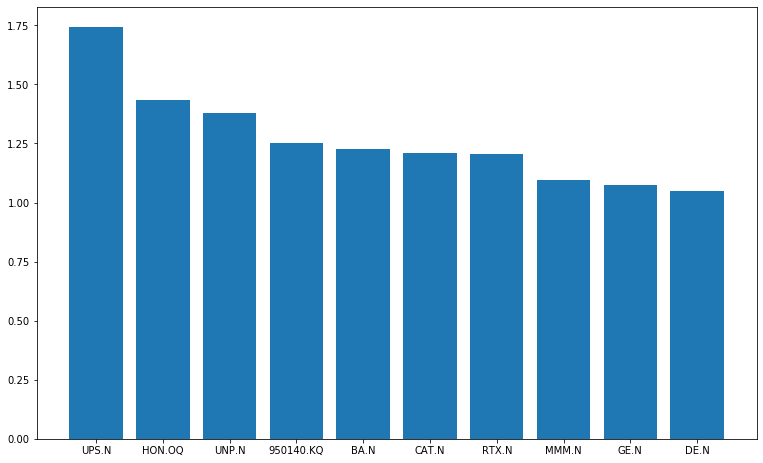

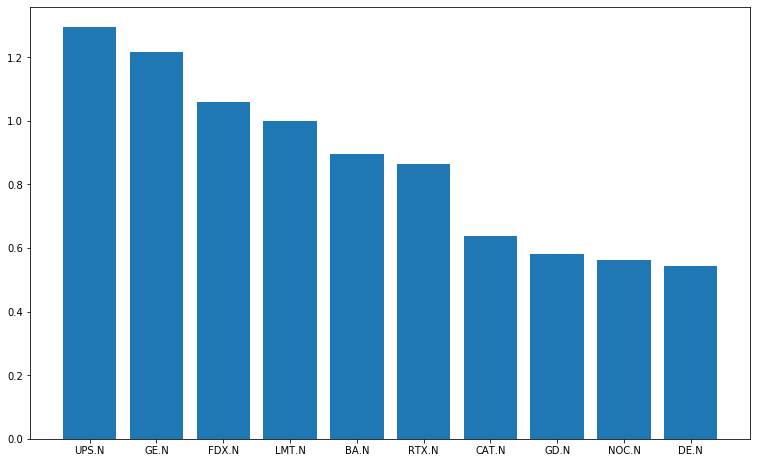

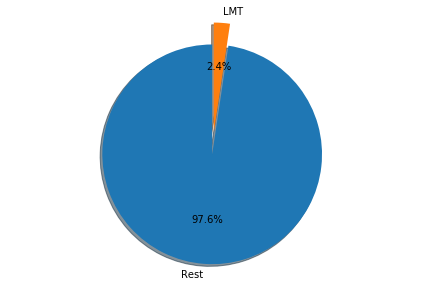

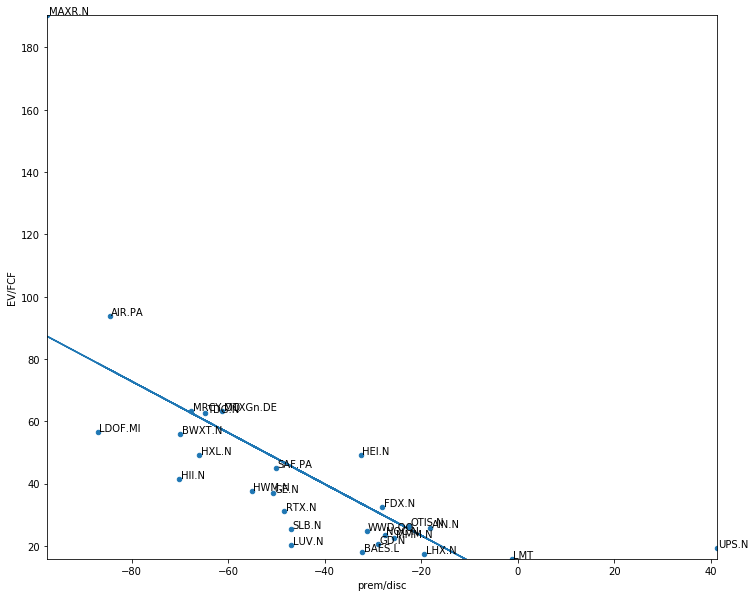

In [31]:
generate_pitchbook('LMT',file_name='pitchbook_vol_1')

'2021-05-19T00:00:00Z'

'2019-05-20T00:00:00Z'

'2016-05-20T00:00:00Z'

'2018-04-27T00:00:00Z'

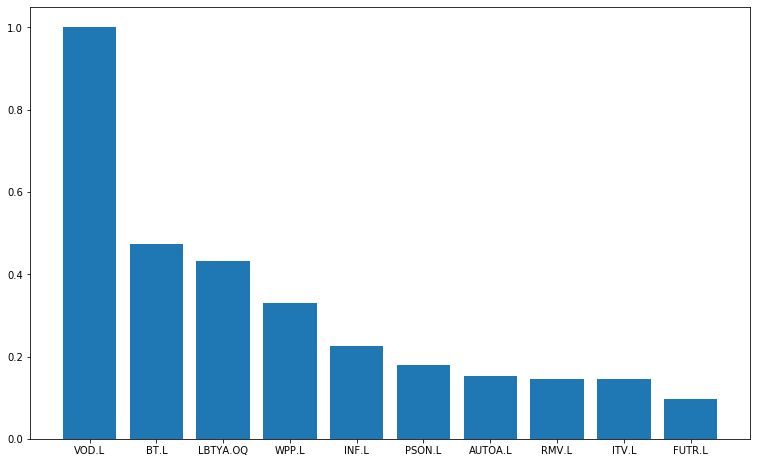

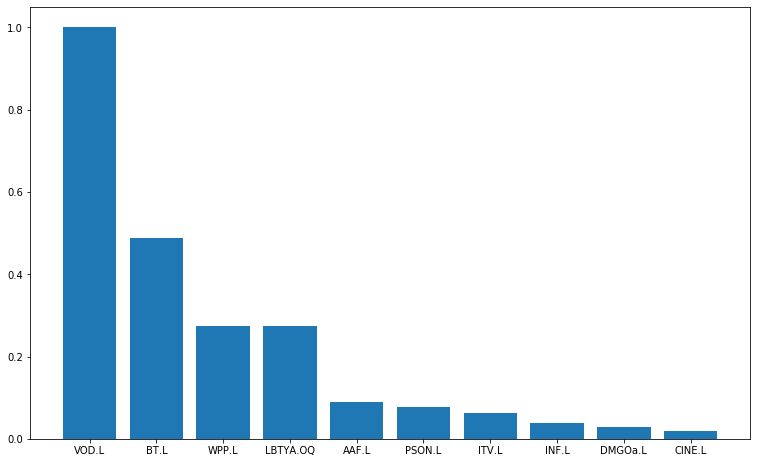

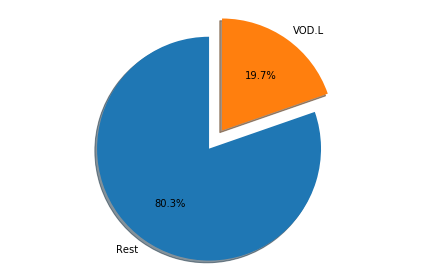

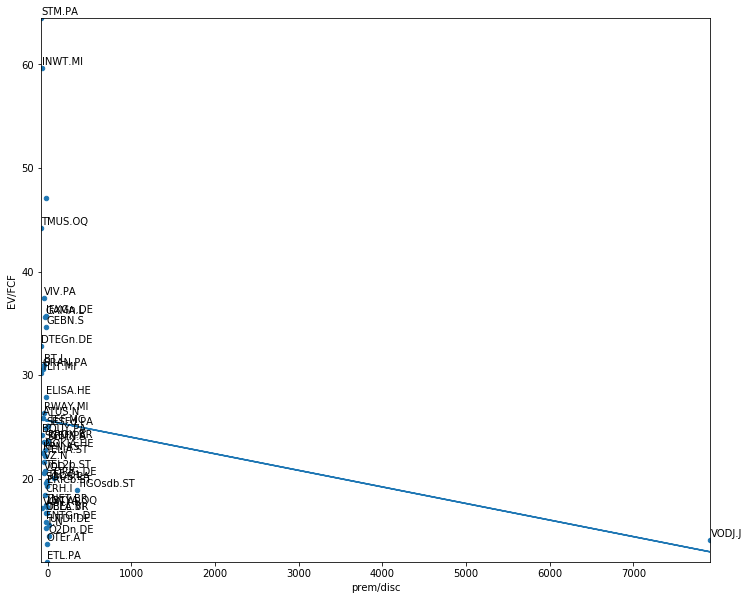

In [28]:
generate_pitchbook('VOD.L',file_name='pitchbook_vol_2')